In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2

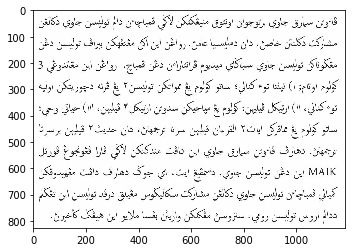

In [2]:
image = cv2.cvtColor(cv2.imread("semarak-jawi.2.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [3]:
SMALL_HEIGHT = 800

def resize(img, height=SMALL_HEIGHT, allways=False):
    """Resize image to given height."""
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img

def implt(img, cmp=None, t=''):
    """Show image using plt."""
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()
    
def ratio(img, height=SMALL_HEIGHT):
    """Getting scale ratio."""
    return img.shape[0] / height

def edges_det(img, min_val, max_val):
    """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)

    # Applying blur and threshold
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    implt(img, 'gray', 'Adaptive Threshold')

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    # Contour can't touch side of image
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    implt(img, 'gray', 'Median Blur + Border')

    return cv2.Canny(img, min_val, max_val)

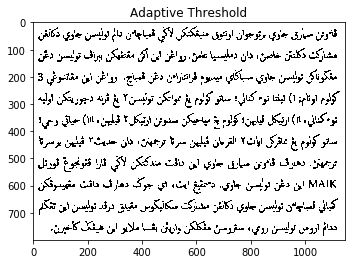

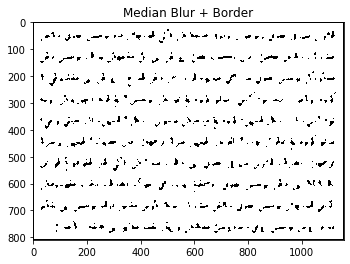

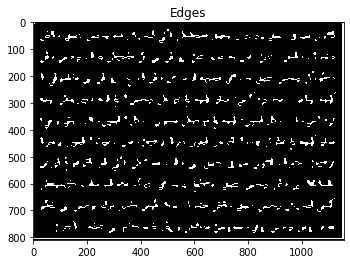

In [4]:
edges_image = edges_det(image, 200, 250)

# Close gaps between edges (double page clouse => rectangle kernel)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
implt(edges_image, 'gray', 'Edges')

In [5]:

def four_corners_sort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contour_offset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def find_page_contours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = four_corners_sort(page_contour)
    return contour_offset(page_contour, (-5, -5))

PAGE CONTOUR:
[[   0    1]
 [   0  799]
 [1146  798]
 [1145    0]]


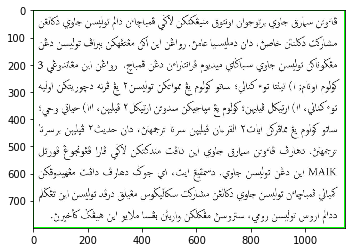

In [6]:
page_contour = find_page_contours(edges_image, resize(image))
print("PAGE CONTOUR:")
print(page_contour)
implt(cv2.drawContours(resize(image), [page_contour], -1, (0, 255, 0), 3))

       
# Recalculate to original scale
page_contour = page_contour.dot(ratio(image))

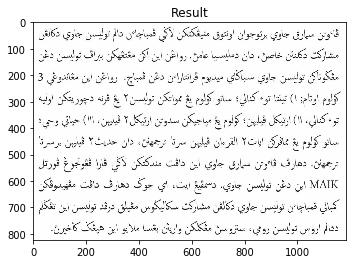

In [7]:
def persp_transform(img, s_points):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = persp_transform(image, page_contour)
#image = newImage
#implt(newImage, t='Result')

image = newImage
implt(image, t='Result')

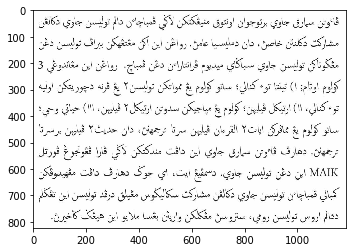

In [8]:
img = cv2.cvtColor(newImage, cv2.COLOR_RGB2GRAY)
implt(img, 'gray')

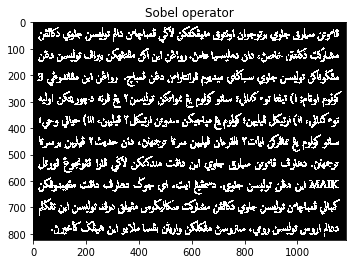

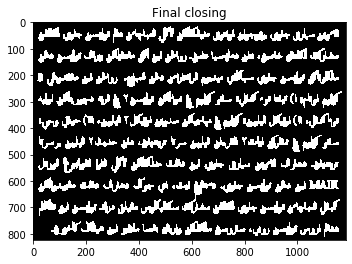

In [240]:
def sobel(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def edge_detect(im):
    """ 
    Edge detection 
    The Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([sobel(im[:,:, 0]), sobel(im[:,:, 1]), sobel(im[:,:, 2]) ]), axis=0)

# Image pre-processing - blur, edges, threshold, closing
#blurred = cv2.GaussianBlur(image, (1,1), 20)
edges = edge_detect(image)
ret, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((5, 4), np.uint8))

implt(edges, 'gray', 'Sobel operator')
implt(bw_image, 'gray', 'Final closing')

In [235]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def intersect(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    print(w)
    if w<0 or h<0:
        return False
    return True

def group_rectangles(rec):
    """
    Uion intersecting rectangles
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
            
    return final

In [236]:
def text_detect(img, original):
    """ Text detection using contours """
    # Resize image
    small = resize(img, 2000)
    image = resize(original, 2000)
    cp_image = image.copy()
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    implt(img, 'gray')
    
    # Variables for contour index and words' bounding boxes
    index = 0    
    boxes = []
    # CCOMP hierarchy: [Next, Previous, First Child, Parent]
    # cv2.RETR_CCOMP - contours into 2 levels
    # Go through all contours in first level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        # Get only the contour
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text (white pixel ratio, width, height)
        # TODO Test h/w and w/h ratios
        if r > 0.1 and 2000 > w > 10 and 1600 > h > 10 and h/w < 3 and w/h < 10:
            boxes += [[x, y, w, h]]
        
        # Index of next contour
        index = hierarchy[0][index][0]
        
    # Group intersecting rectangles
    #boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(cp_image, (x, y),(x+w,y+h), (0, 255, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x+w, y+h])))

    implt(cp_image, t='Bounding rectangles')

    # Recalculate coordinates to original scale
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    return boxes[1:]

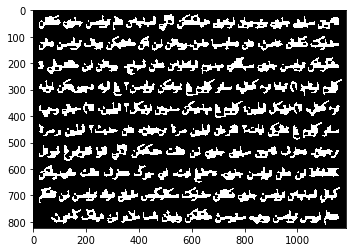

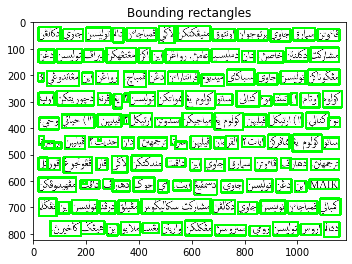

Number of boxes: 131


In [237]:
boxes = text_detect(bw_image, image)
print("Number of boxes:", len(boxes))

In [241]:
def sort_words(box):
    boxes = box.copy()
    """Sort boxes - (x, y, x+w, y+h) from left to right, top to bottom."""
    mean_height = sum([y2 - y1 for _, y1, _, y2 in boxes]) / len(boxes)
    
    boxes.view('i8,i8,i8,i8').sort(order=['f1'], axis=0)
    current_line = boxes[0][1]
    lines = []
    tmp_line = []
    for box in boxes:
        if box[1] > current_line + mean_height:
            lines.append(tmp_line)
            tmp_line = [box]
            current_line = box[1]            
            continue
        tmp_line.append(box)
    lines.append(tmp_line)
        
    for line in lines:
        line.sort(key=lambda box: box[0])
        
    return lines

In [251]:
sorted_boxes = sort_words(boxes)
sorted_boxes

[[array([ 21,  18, 104,  71]),
  array([114,  27, 188,  72]),
  array([199,  20, 294,  71]),
  array([302,  22, 342,  77]),
  array([353,  23, 466,  69]),
  array([475,  15, 535,  79]),
  array([545,  14, 670,  71]),
  array([680,  27, 763,  70]),
  array([773,  27, 887,  70]),
  array([897,  27, 973,  73]),
  array([ 982,   23, 1066,   69]),
  array([1075,   25, 1158,   71])],
 [array([ 21, 103,  81, 152]),
  array([ 90, 102, 185, 152]),
  array([192, 104, 266, 150]),
  array([277,  97, 388, 152]),
  array([398,  97, 441, 152]),
  array([449, 109, 490, 153]),
  array([500, 104, 665, 153]),
  array([674, 101, 779, 150]),
  array([789, 109, 837, 151]),
  array([849, 109, 946, 153]),
  array([ 956,   97, 1038,  149]),
  array([1048,   96, 1157,  151])],
 [array([ 18, 191,  40, 224]),
  array([ 53, 184, 174, 242]),
  array([185, 190, 226, 234]),
  array([237, 185, 321, 234]),
  array([344, 186, 427, 244]),
  array([439, 185, 498, 234]),
  array([509, 187, 625, 232]),
  array([636, 198, 72

In [243]:
x1, y1, x2, y2 = sorted_boxes[0][-2]

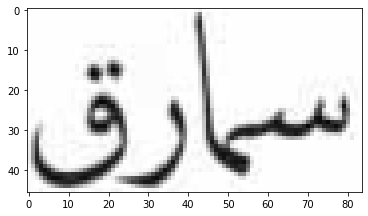

In [244]:
plt.imshow(image[y1: y2, x1:x2])

In [17]:
image.shape

(823, 1183, 3)

In [18]:
import glob
wikis = glob.glob('wiki/*.png')
len(wikis)

268361

In [19]:
wikis[-1]

'wiki/ternyata memberi.png'

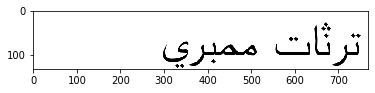

In [22]:
image_ = cv2.cvtColor(cv2.imread(wikis[-1]), cv2.COLOR_BGR2RGB)
plt.imshow(image_)

In [21]:
image[y1: y2, x1:x2]

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[249, 249, 249],
        [252, 252, 252],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[248, 248, 248],
        [253, 253, 253],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[248, 248, 248],
        [253, 253, 253],
        [252, 252, 252],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

In [250]:
class HysterThresh:    
    def __init__(self, img):
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
        hist, bins = np.histogram(img.ravel(), 256, [0,256])
        
        self.high = np.argmax(hist) + 65
        self.low = np.argmax(hist) + 45
        self.diff = 255 - self.high
        
        self.img = img
        self.im = np.zeros(img.shape, dtype=img.dtype)
        self.hyster()
        
    def hyster_rec(self, r, c):
        h, w = self.img.shape
        for ri in [r-1, r+1]:
            for ci in [c-1, c+1]:
                if (h > ri >= 0
                    and w > ci >= 0
                    and self.im[ri, ci] == 0
                    and self.high > self.img[ri, ci] >= self.low):                    
                    self.im[ri, ci] = self.img[ri, ci] + self.diff
                    self.hyster_rec(ri, ci)                
                    
    def hyster(self):
        r, c = self.img.shape
        for ri in range(r):
            for ci in range(c):
                if (self.img[ri, ci] >= self.high):
                    self.im[ri, ci] = 255
                    self.img[ri, ci] = 255
                    self.hyster_rec(ri, ci)
                    
        implt(self.im, 'gray', 'Hister Thresh')


def binary_otsu_norm(img):    
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)


def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = 255 - img
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
    hist, bins = np.histogram(img.ravel(), 256, [0,256])
    
    img = img.astype(np.uint8)

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)

def normalization2(img):    
    implt(255 - img, 'gray', 'Original')   
    implt(255 - bilateral_norm(img), 'gray', 'Bilateral')
    implt(255 - binary_otsu_norm(img), 'gray', 'Binary OTSU')
    implt(histogram_norm(img), 'gray', 'Binary OTSU + (Filter + TO_ZERO)')
    HysterThresh(cv2.bilateralFilter(img, 10, 10, 30))

In [248]:
histogram_norm(image[y1: y2, x1:x2, 0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

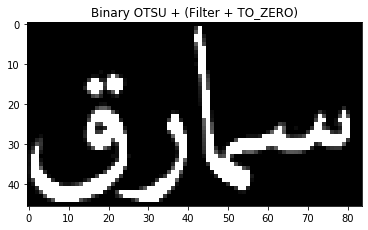

In [249]:
implt(histogram_norm(image[y1: y2, x1:x2, 0]), 'gray', 'Binary OTSU + (Filter + TO_ZERO)')

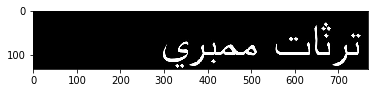

In [32]:
implt(cv2.bitwise_not(image_))

In [227]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    blur_size = int(4*sigma) | 1
    dx = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)
    dy = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    image =  map_coordinates(image, indices, order=1, mode='constant').reshape(shape)
    
    implt(image, 'gray')
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    print(center_square)
    square_size = min(shape_size) // 4
    pts1 = np.float32([center_square + square_size,
                       [center_square[0]+square_size, 
                        center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_CONSTANT)

    return image

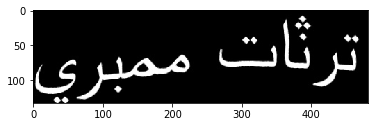

[ 66. 241.]


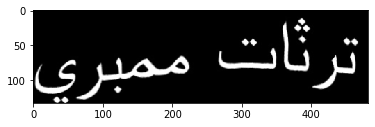

In [228]:
im = cv2.bitwise_not(image_)[:,:,0]
im = im[:, np.min(np.where(im > 0)[1]) - 10:]
implt(elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.2, im.shape[1] * 0.001), 'gray')